In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import glob
import seaborn as sns

In [14]:
def read_vcf(path):
    with open(path, 'r') as f:
        lines = [l for l in f if not l.startswith('##')]
    return pd.read_csv(
        io.StringIO(''.join(lines)),
        dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
               'QUAL': str, 'FILTER': str, 'INFO': str},
        sep='\t'
    ).rename(columns={'#CHROM': 'CHROM'})

In [15]:
# the subset 26 samples' vcf file is generating using "bcftools view -s" with selected sample ID on the genotype file from pangenie_merged_bi_nosnvs.vcf.gz
# be sure to download the file under the same directory as your analysis

pangenie_svs_sample = read_vcf("../data/pangenie_merged_bi_nosnvs_26sample.vcf")

In [16]:
pangenie_svs_sample.shape

(1129810, 35)

In [17]:
pangenie_svs_sample[['INFO_ID']] = pangenie_svs_sample['INFO'].str.split(';', expand=True)[2]
pangenie_svs_sample['INFO_ID'] = pangenie_svs_sample['INFO_ID'].str.lstrip('ID=')
pangenie_DEL_sample = pangenie_svs_sample[pangenie_svs_sample['INFO_ID'].str.contains('DEL')]
pangenie_INS_sample = pangenie_svs_sample[pangenie_svs_sample['INFO_ID'].str.contains('INS')]

In [18]:
pangenie_svs_sample['type'] = pangenie_svs_sample['INFO_ID'].str.split('-', expand=True)[2]
col_list = pangenie_svs_sample['type'].values.tolist()
pd.Series(col_list).value_counts()

DEL    672432
INS    457378
dtype: int64

## deletion 

In [22]:
pangenie_DEL_sample_new = pangenie_DEL_sample[[
'CHROM', 'FILTER', 'INFO_ID', 'FORMAT',
    'NA18534','NA18939','NA19036','NA19240','NA19650','NA19983','NA20509','NA20847','HG00096','HG00171',
    'HG00514','HG00733','HG00864','HG01114','HG01505','HG01573','HG01596','HG02011','HG02018','HG02492',
    'HG02587','HG03009','HG03065','HG03371','HG03683','HG03732'
    ]]
# removed NA12329

In [23]:
pangenie_DEL_sample_new_copy = pangenie_DEL_sample_new.copy()
for col in pangenie_DEL_sample_new_copy.columns[4:]:
    pangenie_DEL_sample_new_copy[col] = pangenie_DEL_sample_new_copy[col].str[:3]

In [24]:
for col in pangenie_DEL_sample_new_copy.columns:
    pangenie_DEL_sample_new_copy.loc[pangenie_DEL_sample_new_copy[col].astype(str).str.startswith('0/0'), col] = '0'
    pangenie_DEL_sample_new_copy.loc[pangenie_DEL_sample_new_copy[col].astype(str).str.startswith('0/1'), col] = '1'
    pangenie_DEL_sample_new_copy.loc[pangenie_DEL_sample_new_copy[col].astype(str).str.startswith('1/0'), col] = '1'
    pangenie_DEL_sample_new_copy.loc[pangenie_DEL_sample_new_copy[col].astype(str).str.startswith('1/1'), col] = '1'

In [25]:
pangenie_DEL_sample_new_copy.shape

(672432, 30)

In [26]:
# Function to convert to integer if possible
def convert_to_int(val):
    try:
        return int(val)
    except ValueError:
        return val

In [27]:
# Apply the conversion function to each cell in the relevant columns to keep the original DataFrame unchanged
pangenie_DEL_sample_new_copy.iloc[:, 4:] = pangenie_DEL_sample_new_copy.iloc[:, 4:].applymap(convert_to_int)
# Create a separate DataFrame for numeric operations
numeric_data = pangenie_DEL_sample_new_copy.iloc[:, 4:].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)
# Calculate the sum of integer values
pangenie_DEL_sample_new_copy['Sum'] = numeric_data.sum(axis=1)
# Filter the DataFrame based on the sum condition
pangenie_DEL_sample_new_copy_atleast5 = pangenie_DEL_sample_new_copy[pangenie_DEL_sample_new_copy['Sum'] >= 5]

In [28]:
# Function to count occurrences of missing genotype ".:."
def count_dot_colon(row):
    return (row == '.:.').sum()

In [29]:
# Make a copy of the DataFrame to avoid modifying the original data
pangenie_DEL_sample_new_copy_atleast5 = pangenie_DEL_sample_new_copy_atleast5.copy()
# Apply the function to each row starting from the 4th column
pangenie_DEL_sample_new_copy_atleast5.loc[:, 'missing_geno'] = pangenie_DEL_sample_new_copy_atleast5.iloc[:, 4:].apply(count_dot_colon, axis=1)

In [30]:
pangenie_DEL_sample_new_copy_atleast5['missing_geno'].max()

18

In [31]:
pangenie_DEL_sample_new_copy_atleast5.shape

(261955, 32)

In [32]:
# require less than 50% of samples have missing genotypes 
pangenie_DEL_sample_new_copy_atleast5_filter = pangenie_DEL_sample_new_copy_atleast5[pangenie_DEL_sample_new_copy_atleast5['missing_geno'] < 13]
pangenie_DEL_sample_new_copy_atleast5_filter.shape

(261950, 32)

In [33]:
pangenie_DEL_sample_new_copy_atleast5_filter = pangenie_DEL_sample_new_copy_atleast5_filter.copy()
pangenie_DEL_sample_new_copy_atleast5_filter['START_POS'] = pangenie_DEL_sample_new_copy_atleast5_filter['INFO_ID'].str.split('-', expand=True)[1]
pangenie_DEL_sample_new_copy_atleast5_filter['TYPE'] = pangenie_DEL_sample_new_copy_atleast5_filter['INFO_ID'].str.split('-', expand=True)[2]
pangenie_DEL_sample_new_copy_atleast5_filter['LEN'] = pangenie_DEL_sample_new_copy_atleast5_filter['INFO_ID'].str.split('-', expand=True)[3]
pangenie_DEL_sample_new_copy_atleast5_filter.iloc[:,[32,34]] = pangenie_DEL_sample_new_copy_atleast5_filter.iloc[:,[32,34]].astype(str).astype(int)
pangenie_DEL_sample_new_copy_atleast5_filter['END_POS'] = pangenie_DEL_sample_new_copy_atleast5_filter['START_POS'] + pangenie_DEL_sample_new_copy_atleast5_filter['LEN'] - 1
pangenie_DEL_sample_new_copy_atleast5_filter_new = pangenie_DEL_sample_new_copy_atleast5_filter[[
'CHROM', 'START_POS','END_POS', 'TYPE','LEN', 'FILTER', 'INFO_ID', 'FORMAT', 'NA18534','NA18939','NA19036','NA19240','NA19650','NA19983','NA20509','NA20847','HG00096','HG00171','HG00514','HG00733','HG00864','HG01114','HG01505','HG01573','HG01596','HG02011','HG02018','HG02492','HG02587','HG03009','HG03065','HG03371','HG03683','HG03732', 'Sum', 'missing_geno'
    ]]

In [34]:
pangenie_DEL_sample_new_atleast5_50 = pangenie_DEL_sample_new_copy_atleast5_filter_new[pangenie_DEL_sample_new_copy_atleast5_filter_new['LEN'] >= 50]
pangenie_DEL_sample_new_atleast5_50.shape

(13873, 36)

In [35]:
pangenie_DEL_sample_new_atleast5_50_zero = pangenie_DEL_sample_new_atleast5_50[pangenie_DEL_sample_new_atleast5_50.iloc[:, 8:34].eq(0).any(1)]
pangenie_DEL_sample_new_atleast5_50_zero.shape

(12655, 36)

In [36]:
pangenie_DEL_sample_new_atleast5_50_zero.to_csv('../preprocess_data/pangenie_svs_26sample_ALL_DEL_atleast5_50_genotype_only01.bed', index = False, sep='\t', header=True)

In [37]:
pangenie_DEL_sample_new_atleast5_50_start_end = pangenie_DEL_sample_new_atleast5_50_zero[['CHROM', 'START_POS', 'END_POS', 'INFO_ID']]
pangenie_DEL_sample_new_atleast5_50_start_end.shape

(12655, 4)

In [38]:
pangenie_DEL_sample_new_atleast5_50_start_end.to_csv('../preprocess_data/pangenie_svs_26sample_ALL_DEL_atleast5_50_only01.bed', index = False, sep='\t', header=True)

## insertion

In [39]:
pangenie_INS_sample_new = pangenie_INS_sample[[
'CHROM', 'FILTER', 'INFO_ID', 'FORMAT','NA18534','NA18939','NA19036','NA19240','NA19650','NA19983','NA20509','NA20847','HG00096','HG00171','HG00514','HG00733','HG00864','HG01114','HG01505','HG01573','HG01596','HG02011','HG02018','HG02492','HG02587','HG03009','HG03065','HG03371','HG03683','HG03732'
    ]]
# removed NA12329

In [40]:
pangenie_INS_sample_new_copy = pangenie_INS_sample_new.copy()
for col in pangenie_INS_sample_new_copy.iloc[:, 4:]:
    pangenie_INS_sample_new_copy[col] = pangenie_INS_sample_new_copy[col].str[:3]

In [41]:
for col in pangenie_INS_sample_new_copy.columns:
    pangenie_INS_sample_new_copy.loc[pangenie_INS_sample_new_copy[col].astype(str).str.startswith('0/0'), col] = '0'
    pangenie_INS_sample_new_copy.loc[pangenie_INS_sample_new_copy[col].astype(str).str.startswith('0/1'), col] = '1'
    pangenie_INS_sample_new_copy.loc[pangenie_INS_sample_new_copy[col].astype(str).str.startswith('1/0'), col] = '1'
    pangenie_INS_sample_new_copy.loc[pangenie_INS_sample_new_copy[col].astype(str).str.startswith('1/1'), col] = '1'

In [42]:
pangenie_INS_sample_new_copy.shape

(457378, 30)

In [43]:
# Apply the conversion function to each cell in the relevant columns to keep the original DataFrame unchanged
pangenie_INS_sample_new_copy.iloc[:, 4:] = pangenie_INS_sample_new_copy.iloc[:, 4:].applymap(convert_to_int)
# Create a separate DataFrame for numeric operations
numeric_data = pangenie_INS_sample_new_copy.iloc[:, 4:].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)
# Calculate the sum of integer values
pangenie_INS_sample_new_copy['Sum'] = numeric_data.sum(axis=1)
# Filter the DataFrame based on the sum condition
pangenie_INS_sample_new_copy_atleast5 = pangenie_INS_sample_new_copy[pangenie_INS_sample_new_copy['Sum'] >= 5]

In [44]:
# Make a copy of the DataFrame to avoid modifying the original data
pangenie_INS_sample_new_copy_atleast5 = pangenie_INS_sample_new_copy_atleast5.copy()
# Apply the function to each row starting from the 4th column
pangenie_INS_sample_new_copy_atleast5.loc[:, 'missing_geno'] = pangenie_INS_sample_new_copy_atleast5.iloc[:, 4:].apply(count_dot_colon, axis=1)

In [45]:
pangenie_INS_sample_new_copy_atleast5['missing_geno'].max()

13

In [46]:
pangenie_INS_sample_new_copy_atleast5.shape

(239051, 32)

In [47]:
# require less than 50% of samples have missing genotypes 
pangenie_INS_sample_new_copy_atleast5_filter = pangenie_INS_sample_new_copy_atleast5[pangenie_INS_sample_new_copy_atleast5['missing_geno'] < 13]
pangenie_INS_sample_new_copy_atleast5_filter.shape

(239046, 32)

In [48]:
pangenie_INS_sample_new_copy_atleast5_filter = pangenie_INS_sample_new_copy_atleast5_filter.copy()
pangenie_INS_sample_new_copy_atleast5_filter['START_POS'] = pangenie_INS_sample_new_copy_atleast5_filter['INFO_ID'].str.split('-', expand=True)[1]
pangenie_INS_sample_new_copy_atleast5_filter['TYPE'] = pangenie_INS_sample_new_copy_atleast5_filter['INFO_ID'].str.split('-', expand=True)[2]
pangenie_INS_sample_new_copy_atleast5_filter['LEN'] = pangenie_INS_sample_new_copy_atleast5_filter['INFO_ID'].str.split('-', expand=True)[3]
pangenie_INS_sample_new_copy_atleast5_filter.iloc[:,[32,34]] = pangenie_INS_sample_new_copy_atleast5_filter.iloc[:,[32,34]].astype(str).astype(int)
pangenie_INS_sample_new_copy_atleast5_filter['END_POS'] = pangenie_INS_sample_new_copy_atleast5_filter['START_POS']
pangenie_INS_sample_new_copy_atleast5_filter_new = pangenie_INS_sample_new_copy_atleast5_filter[[
'CHROM', 'START_POS','END_POS', 'TYPE','LEN', 'FILTER', 'INFO_ID', 'FORMAT', 'NA18534','NA18939','NA19036','NA19240','NA19650','NA19983','NA20509','NA20847','HG00096','HG00171','HG00514','HG00733','HG00864','HG01114','HG01505','HG01573','HG01596','HG02011','HG02018','HG02492','HG02587','HG03009','HG03065','HG03371','HG03683','HG03732', 'Sum', 'missing_geno'
    ]]

In [49]:
pangenie_INS_sample_new_atleast5_50 = pangenie_INS_sample_new_copy_atleast5_filter_new[pangenie_INS_sample_new_copy_atleast5_filter_new['LEN'] >= 50]
pangenie_INS_sample_new_atleast5_50.shape

(19990, 36)

In [50]:
pangenie_INS_sample_new_atleast5_50_zero = pangenie_INS_sample_new_atleast5_50[pangenie_INS_sample_new_atleast5_50.iloc[:, 8:34].eq(0).any(1)]
pangenie_INS_sample_new_atleast5_50_zero.shape

(17257, 36)

In [51]:
pangenie_INS_sample_new_atleast5_50_zero.to_csv('../preprocess_data/pangenie_svs_26sample_ALL_INS_atleast5_50_genotype_only01.bed', index = False, sep='\t', header=True)

In [52]:
pangenie_INS_sample_new_atleast5_50_start_end = pangenie_INS_sample_new_atleast5_50_zero[['CHROM', 'START_POS', 'END_POS', 'INFO_ID']]
pangenie_INS_sample_new_atleast5_50_start_end.shape

(17257, 4)

In [53]:
pangenie_INS_sample_new_atleast5_50_start_end.to_csv('../preprocess_data/pangenie_svs_26sample_ALL_INS_atleast5_50_only01.bed', index = False, sep='\t', header=True)

In [54]:
len(pangenie_DEL_sample_new_atleast5_50_zero)

12655

In [55]:
len(pangenie_INS_sample_new_atleast5_50_zero)

17257

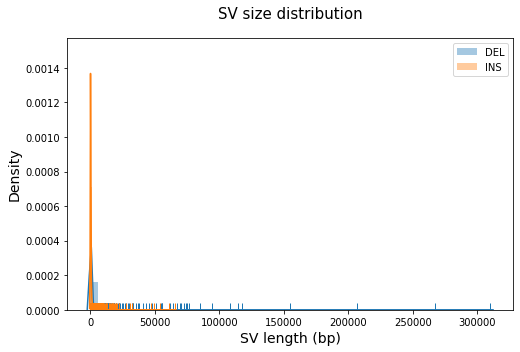

In [64]:
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
                      
plt.rcParams['figure.figsize'] = [8, 5]
gfg = sns.distplot(pangenie_DEL_sample_new_atleast5_50_zero['LEN'], rug=True,kde=True, label='DEL')
gfg = sns.distplot(pangenie_INS_sample_new_atleast5_50_zero['LEN'], rug=True, kde=True, label='INS')
plt.xlabel('SV length (bp)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('SV size distribution', fontsize=15, y=1.05)
plt.legend()

### SVs' impact on boundary strength 

In [66]:
all_DEL_merged = pd.read_csv('../data/all_DEL_26merged_cutoff_flank_inter30_5kb_boundaries_100kb_only01.bed', sep='\t', header=None)
all_DEL_merged.columns =['CHROM', 'START_POS', 'END_POS', 'INFO_ID', 'BOUND_CHR', 'FLANK_START', 'FLANK_END', 'BOUND_SCORE']
all_INS_merged = pd.read_csv('../data/all_INS_26merged_cutoff_flank_inter30_5kb_boundaries_100kb_only01.bed', sep='\t', header=None)
all_INS_merged.columns =['CHROM', 'START_POS', 'END_POS', 'INFO_ID', 'BOUND_CHR', 'FLANK_START', 'FLANK_END', 'BOUND_SCORE']

In [67]:
all_DEL_merged.shape

(12713, 8)

In [68]:
all_INS_merged.shape

(17302, 8)

In [69]:
all_DEL_boundary_1 = all_DEL_merged.loc[all_DEL_merged.iloc[:, 4] != '.']
all_DEL_boundary_2 = all_DEL_boundary_1.reset_index(drop=True)
all_INS_boundary_1 = all_INS_merged.loc[all_INS_merged.iloc[:, 4] != '.']
all_INS_boundary_2 = all_INS_boundary_1.reset_index(drop=True)

In [70]:
all_DEL_boundary_2.shape

(1838, 8)

In [71]:
all_INS_boundary_2.shape

(2605, 8)

In [72]:
len(all_DEL_boundary_2['INFO_ID'].drop_duplicates())

1780

In [73]:
len(all_INS_boundary_2['INFO_ID'].drop_duplicates())

2560

In [74]:
sample_ids = ['GM18534','GM18939','GM19036','GM19240','GM19650','GM19833','GM20509','GM20847','HG00096','HG00171',
              'HG00514','HG00733','HG00864','HG01114','HG01505','HG01573','HG01596','HG02011','HG02018','HG02492',
              'HG02587','HG03009','HG03065','HG03371','HG03683','HG03732']

for i in sample_ids:
    file_pattern = os.path.join(f"../data/sample_bound/{i}_BS_cutoff_inter30_10kb.boundaries_100kb.bed")    
    sample_file = glob.glob(file_pattern)
    sample_merged_BS = pd.read_csv(sample_file[0], sep='\t', header=None)
    #sample_merged_BS = pd.read_csv(sample_file[0], sep='\t', header=None)
    sample_merged_BS =sample_merged_BS[[0, 1, 2, 3, 4, 5, 6, 8]]
    sample_merged_BS.columns =['BOUND_CHR', 'FLANK_START', 'FLANK_END', 'BOUND_SCORE','BOUND_CHR_samp', 'BOUND_START_samp', 'BOUND_END_samp', 'BOUND_SCORE_samp']
    sample_merged_BS_1 = sample_merged_BS.groupby(['BOUND_CHR', 'FLANK_START', 'FLANK_END'], as_index=False)['BOUND_SCORE_samp'].median()
    all_DEL_boundary_2[i] = all_DEL_boundary_2.merge(sample_merged_BS_1, how="left", left_on=["BOUND_CHR", "FLANK_START", "FLANK_END"], right_on=["BOUND_CHR", "FLANK_START", "FLANK_END"])['BOUND_SCORE_samp']
    all_INS_boundary_2[i] = all_INS_boundary_2.merge(sample_merged_BS_1, how="left", left_on=["BOUND_CHR", "FLANK_START", "FLANK_END"], right_on=["BOUND_CHR", "FLANK_START", "FLANK_END"])['BOUND_SCORE_samp']

In [75]:
all_DEL_boundary_2.shape

(1838, 34)

In [76]:
all_INS_boundary_2.shape

(2605, 34)

#### Mann-Whitney U test for genotypes and boundary BS

In [77]:
all_DEL_boundary_2['num_NaNs'] = all_DEL_boundary_2.iloc[:, 8:].isna().sum(1)
all_INS_boundary_2['num_NaNs'] = all_INS_boundary_2.iloc[:, 8:].isna().sum(1)

In [78]:
all_DEL_boundary_2_noNA = all_DEL_boundary_2[all_DEL_boundary_2.num_NaNs < 26]
all_INS_boundary_2_noNA = all_INS_boundary_2[all_INS_boundary_2.num_NaNs < 26]

In [86]:
# Replace NaN Values with Zeros, because those NA boundary scores mean there is no boundary, so we changed them to zero
all_DEL_boundary_3 = all_DEL_boundary_2_noNA.fillna(0).drop_duplicates().reset_index(drop=True)
all_DEL_boundary_3.shape

(1794, 35)

In [87]:
# Replace NaN Values with Zeros
all_INS_boundary_3 = all_INS_boundary_2_noNA.fillna(0).drop_duplicates().reset_index(drop=True)
all_INS_boundary_3.shape

(2551, 35)

In [88]:
all_DEL_boundary_id = list(all_DEL_boundary_3['INFO_ID'])
DEL_list = list(set(all_DEL_boundary_id))
len(DEL_list)

1740

In [89]:
all_INS_boundary_id = list(all_INS_boundary_3['INFO_ID'])
INS_list = list(set(all_INS_boundary_id))
len(INS_list)

2510

In [92]:
len(all_DEL_boundary_3[['BOUND_CHR', 'FLANK_START', 'FLANK_END']].drop_duplicates())

1413

In [93]:
len(all_INS_boundary_3[['BOUND_CHR', 'FLANK_START', 'FLANK_END']].drop_duplicates())

1750

In [94]:
DEL_genotype = pd.read_csv('../preprocess_data/pangenie_svs_26sample_ALL_DEL_atleast5_50_genotype_only01.bed', sep='\t', header=0, dtype=str)
INS_genotype = pd.read_csv('../preprocess_data/pangenie_svs_26sample_ALL_INS_atleast5_50_genotype_only01.bed', sep='\t', header=0, dtype=str)

In [95]:
DEL_genotype_1 = DEL_genotype.iloc[:, :-1]
INS_genotype_1 = INS_genotype.iloc[:, :-1]
DEL_boundary_genotype = DEL_genotype_1[DEL_genotype_1['INFO_ID'].isin(all_DEL_boundary_id)]
INS_boundary_genotype = INS_genotype_1[INS_genotype_1['INFO_ID'].isin(all_INS_boundary_id)]
DEL_boundary_genotype = DEL_boundary_genotype[[
'CHROM', 'START_POS', 'END_POS', 'TYPE', 'LEN', 'FILTER', 'INFO_ID','FORMAT','NA18534','NA18939','NA19036','NA19240','NA19650','NA19983','NA20509','NA20847','HG00096','HG00171','HG00514','HG00733','HG00864','HG01114','HG01505','HG01573','HG01596','HG02011','HG02018','HG02492','HG02587','HG03009','HG03065','HG03371','HG03683','HG03732'
    ]]
INS_boundary_genotype = INS_boundary_genotype[[
'CHROM', 'START_POS', 'END_POS', 'TYPE', 'LEN', 'FILTER', 'INFO_ID','FORMAT','NA18534','NA18939','NA19036','NA19240','NA19650','NA19983','NA20509','NA20847','HG00096','HG00171','HG00514','HG00733','HG00864','HG01114','HG01505','HG01573','HG01596','HG02011','HG02018','HG02492','HG02587','HG03009','HG03065','HG03371','HG03683','HG03732'
    ]]

In [96]:
DEL_boundary_genotype_1 = DEL_boundary_genotype.reset_index(drop=True)
DEL_boundary_genotype_1.shape

(1740, 34)

In [97]:
INS_boundary_genotype_1 = INS_boundary_genotype.reset_index(drop=True)
INS_boundary_genotype_1.shape

(2510, 34)

In [98]:
### test for genotypes 0 and 1 (binary genotypes, only 0/0 and others)
pvalue= []

for i in range(0, len(all_DEL_boundary_3)):
    DEL_boundary_genotype_all = DEL_boundary_genotype_1[DEL_boundary_genotype_1.loc[:,'INFO_ID'] == all_DEL_boundary_3.loc[i,'INFO_ID']].iloc[:,8:]
    genotypes_list = DEL_boundary_genotype_all.iloc[0].values.tolist()
    boundary_score_list = all_DEL_boundary_3.iloc[i,8:34].values.tolist()

    df = pd.DataFrame({'genotypes' : genotypes_list,
                   'boundary_score' : boundary_score_list})
    
    # Convert the 'genotypes' column to string type
    df['genotypes'] = df['genotypes'].astype(str)
    
    df_new = df.assign(BS=df.groupby('genotypes').cumcount()).pivot('BS','genotypes','boundary_score')
      
    try:
        U, p = mannwhitneyu(x=df_new['0'].dropna().tolist(), y=df_new['1'].dropna().tolist(), method="exact", alternative = 'two-sided')
        #print (p)
        
    except ValueError:
        p = 'NA'
        #print (p)
    
    pvalue.append(p)
    
all_DEL_boundary_3['pvalue_0_1'] = pvalue

In [99]:
all_DEL_boundary_3.to_csv('../data/final_ALL_DEL_merged_BS_flank_26sample_pvalue_only01_fillna.bed', index = False, sep='\t', header=True)

In [100]:
### test for genotypes 0 and 1 (binary genotypes, only 0/0 and others)
pvalue= []

for i in range(0, len(all_INS_boundary_3)):
    INS_boundary_genotype_all = INS_boundary_genotype_1[INS_boundary_genotype_1.loc[:,'INFO_ID'] == all_INS_boundary_3.loc[i,'INFO_ID']].iloc[:,8:]
    genotypes_list = INS_boundary_genotype_all.iloc[0].values.tolist()
    boundary_score_list = all_INS_boundary_3.iloc[i,8:34].values.tolist()

    df = pd.DataFrame({'genotypes' : genotypes_list,
                   'boundary_score' : boundary_score_list})
    
    # Convert the 'genotypes' column to string type
    df['genotypes'] = df['genotypes'].astype(str)
    
    df_new = df.assign(BS=df.groupby('genotypes').cumcount()).pivot('BS','genotypes','boundary_score')
      
    try:
        U, p = mannwhitneyu(x=df_new['0'].dropna().tolist(), y=df_new['1'].dropna().tolist(), method="exact", alternative = 'two-sided')
        #print (p)
        
    except ValueError:
        p = 'NA'
        #print (p)
    
    pvalue.append(p)
    
all_INS_boundary_3['pvalue_0_1'] = pvalue

In [101]:
all_INS_boundary_3.to_csv('../data/final_ALL_INS_merged_BS_flank_26sample_pvalue_only01_fillna.bed', index = False, sep='\t', header=True)

In [102]:
def fdr_correction(group):
    _, corrected_pvalues, _, _ = multipletests(group['pvalue_0_1'], method='fdr_bh')
    group['qvalue'] = corrected_pvalues
    return group

In [103]:
corrected_del = all_DEL_boundary_3.groupby('INFO_ID').apply(fdr_correction)
corrected_del.to_csv('../data/final_ALL_DEL_merged_BS_flank_26sample_qvalue_only01_fillna.bed', index = False, sep='\t', header=True)

In [104]:
all_DEL_boundary_3_sig = corrected_del[corrected_del['qvalue'] < 0.05]
all_DEL_boundary_3_sig.to_csv('../data/all_DEL_boundary_3_sig_10kbflank.bed', index = False, sep='\t', header = True)

In [105]:
len(all_DEL_boundary_3_sig['INFO_ID'].drop_duplicates())

66

In [106]:
corrected_ins = all_INS_boundary_3.groupby('INFO_ID').apply(fdr_correction)
corrected_ins.to_csv('../data/final_ALL_INS_merged_BS_flank_26sample_qvalue_only01_fillna.bed', index = False, sep='\t', header=True)

In [107]:
all_INS_boundary_3_sig = corrected_ins[corrected_ins['qvalue'] < 0.05]
all_INS_boundary_3_sig.to_csv('../data/all_INS_boundary_3_sig_10kbflank.bed', index = False, sep='\t', header = True)

In [108]:
len(all_INS_boundary_3_sig['INFO_ID'].drop_duplicates())

119

### TAD-SV subset removing/creating TAD boundaries 

In [118]:
# Initialize new columns in all_DEL_boundary_3_sig
all_DEL_boundary_3_sig = all_DEL_boundary_3_sig.copy()
all_DEL_boundary_3_sig['median_score_geno_0'] = None
all_DEL_boundary_3_sig['median_score_geno_1'] = None
all_DEL_boundary_3_sig['count_bound_0_geno_1'] = 0
all_DEL_boundary_3_sig['count_bound_1_geno_0'] = 0

# For each INFO_ID in all_DEL_boundary_3_sig
for idx, row in all_DEL_boundary_3_sig.iterrows():
    info_id = row['INFO_ID']
    
    # Find the corresponding row in DEL_boundary_genotype_1
    geno_row = DEL_boundary_genotype_1[DEL_boundary_genotype_1['INFO_ID'] == info_id]
    
    if not geno_row.empty:
        # Extract boundary scores and genotypes
        curr_scores = row.iloc[8:34].reset_index(drop=True)
        curr_genos = geno_row.iloc[0, 8:34].reset_index(drop=True)
        
        # Compute median score for genotype group 0 and 1
        median_score_geno_0 = curr_scores[curr_genos == '0'].median()
        median_score_geno_1 = curr_scores[curr_genos == '1'].median()
        
        # Compute count of boundary scores that are 0 when genotype is 1
        count_boundary_0_geno_1 = (curr_scores[curr_genos == '1'] == 0).sum()
        # Compute count of boundary scores that are NOT equals to 0 when genotype is 0
        count_boundary_1_geno_0 = (curr_scores[curr_genos == '0'] != 0).sum()
        
        # Store results in all_DEL_boundary_3_sig
        all_DEL_boundary_3_sig.at[idx, 'median_score_geno_0'] = median_score_geno_0
        all_DEL_boundary_3_sig.at[idx, 'median_score_geno_1'] = median_score_geno_1
        all_DEL_boundary_3_sig.at[idx, 'count_bound_0_geno_1'] = count_boundary_0_geno_1
        all_DEL_boundary_3_sig.at[idx, 'count_bound_1_geno_0'] = count_boundary_1_geno_0

In [121]:
all_DEL_boundary_3_sig_remove_bound = all_DEL_boundary_3_sig[(all_DEL_boundary_3_sig['count_bound_0_geno_1'] > 0) &
                                                             (all_DEL_boundary_3_sig['count_bound_1_geno_0'] > 0) &
                                                            (all_DEL_boundary_3_sig['median_score_geno_1'] < all_DEL_boundary_3_sig['median_score_geno_0'])]
len(all_DEL_boundary_3_sig_remove_bound['INFO_ID'].drop_duplicates())                 

22

In [147]:
all_DEL_boundary_3_sig_remove_bound.to_csv('../data/all_DEL_boundary_3_remove_bound.bed', index = False, sep='\t', header=True)

In [120]:
# Initialize new columns in all_INS_boundary_3_sig
all_INS_boundary_3_sig = all_INS_boundary_3_sig.copy()
all_INS_boundary_3_sig['median_score_geno_0'] = None
all_INS_boundary_3_sig['median_score_geno_1'] = None
all_INS_boundary_3_sig['count_bound_0_geno_0'] = 0
all_INS_boundary_3_sig['count_bound_1_geno_1'] = 0

# For each INFO_ID in all_INS_boundary_3_sig
for idx, row in all_INS_boundary_3_sig.iterrows():
    info_id = row['INFO_ID']
    
    # Find the corresponding row in DEL_boundary_genotype_1
    geno_row = INS_boundary_genotype_1[INS_boundary_genotype_1['INFO_ID'] == info_id]
    
    if not geno_row.empty:
        # Extract boundary scores and genotypes
        curr_scores = row.iloc[8:34].reset_index(drop=True)
        curr_genos = geno_row.iloc[0, 8:34].reset_index(drop=True)
        
        # Compute median score for genotype 0 and 1
        median_score_geno_0 = curr_scores[curr_genos == '0'].median()
        median_score_geno_1 = curr_scores[curr_genos == '1'].median()
        
        # Compute count of boundary scores that are equals to 0 when genotype is 0
        count_boundary_0_geno_0 = (curr_scores[curr_genos == '0'] == 0).sum()
        # Compute count of boundary scores that are NOT equals to 0 when genotype is 1
        count_boundary_1_geno_1 = (curr_scores[curr_genos == '1'] != 0).sum()
        
        # Count samples with genotype 0 and genotype 1
        count_samples_geno_0 = (curr_genos == '0').sum()
        count_samples_geno_1 = (curr_genos == '1').sum()
        
        # Store results in all_INS_boundary_3_sig
        all_INS_boundary_3_sig.at[idx, 'median_score_geno_0'] = median_score_geno_0
        all_INS_boundary_3_sig.at[idx, 'median_score_geno_1'] = median_score_geno_1
        all_INS_boundary_3_sig.at[idx, 'count_bound_0_geno_0'] = count_boundary_0_geno_0
        all_INS_boundary_3_sig.at[idx, 'count_bound_1_geno_1'] = count_boundary_1_geno_1

In [124]:
all_INS_boundary_3_sig_split_TAD = all_INS_boundary_3_sig[(all_INS_boundary_3_sig['count_bound_0_geno_0'] > 0) &
                                                             (all_INS_boundary_3_sig['count_bound_1_geno_1'] > 0) &
                                                            (all_INS_boundary_3_sig['median_score_geno_1'] > all_INS_boundary_3_sig['median_score_geno_0'])]
len(all_INS_boundary_3_sig_split_TAD['INFO_ID'].drop_duplicates())

58

In [125]:
all_INS_boundary_3_sig_split_TAD.to_csv('../data/all_INS_boundary_3_split_TAD.bed', index = False, sep='\t', header=True)

### visualization of chr8-644401-DEL-5014 and chr19-37789443-INS-1092 

In [138]:
all_DEL_boundary_3_sig[all_DEL_boundary_3_sig['INFO_ID'] == 'chr8-644401-DEL-5014']

,CHROM,START_POS,END_POS,INFO_ID,BOUND_CHR,FLANK_START,FLANK_END,BOUND_SCORE,GM18534,GM18939,...,HG03371,HG03683,HG03732,num_NaNs,pvalue_0_1,qvalue,median_score_geno_0,median_score_geno_1,count_bound_0_geno_1,count_bound_1_geno_0
1652,chr8,644401,649414,chr8-644401-DEL-5014,chr8,640001,665000,0.2225252389907837,0.733518,0.0,...,0.0,0.0,0.0,14,0.002524,0.002524,1.064899,0.0,14,5


In [140]:
boundary_score_list = all_DEL_boundary_3_sig.loc[1652][8:34].values.tolist()
DEL_boundary_genotype_all = DEL_boundary_genotype_1[DEL_boundary_genotype_1.loc[:,'INFO_ID'] == all_DEL_boundary_3_sig.loc[1652]['INFO_ID']].iloc[:,8:]
genotypes_list = DEL_boundary_genotype_all.iloc[0].values.tolist()
df = pd.DataFrame({'genotypes' : genotypes_list,
                   'boundary_score' : boundary_score_list})    
df_new = df.assign(BS=df.groupby('genotypes').cumcount()).pivot('BS','genotypes','boundary_score')

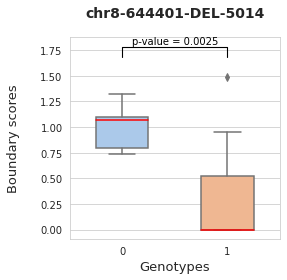

In [142]:


# Set Seaborn's default style and color palette
sns.set_style("whitegrid")
sns.set_palette("pastel")

# Create the boxplot using Seaborn
plt.figure(figsize=(4, 4))  # Adjust the figure size
ax = sns.boxplot(data=df_new[['0', '1']], palette="pastel", medianprops=dict(color='red'), width=0.5)

# Set labels, titles, and other properties
ax.set_ylabel('Boundary scores', fontsize=13, labelpad=20)
ax.set_xlabel('Genotypes', fontsize=13)
ax.set_title('chr8-644401-DEL-5014', pad=20, fontsize=14, fontweight='bold')

# Display the plot
plt.tight_layout()

# statistical annotation
x1, x2 = 0, 1 
y, h, col = df_new['1'].max() + 0.2, 0.1, 'k'

plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.1, c=col)
plt.text((x1+x2)*.5, y+h, "p-value = 0.0025", ha='center', va='bottom', color=col)

plt.show()

In [143]:
all_INS_boundary_3_sig[all_INS_boundary_3_sig['INFO_ID'] == 'chr19-37789443-INS-1092']

,CHROM,START_POS,END_POS,INFO_ID,BOUND_CHR,FLANK_START,FLANK_END,BOUND_SCORE,GM18534,GM18939,...,HG03371,HG03683,HG03732,num_NaNs,pvalue_0_1,qvalue,median_score_geno_0,median_score_geno_1,count_bound_0_geno_0,count_bound_1_geno_1
1184,chr19,37789443,37789443,chr19-37789443-INS-1092,chr19,37780001,37805000,0.2437641769647598,1.533405,0.289078,...,0.340655,0.0,0.61169,6,0.001807,0.001807,0.139963,0.510478,5,15


In [144]:
boundary_score_list = all_INS_boundary_3_sig.loc[1184][8:34].values.tolist()
INS_boundary_genotype_all = INS_boundary_genotype_1[INS_boundary_genotype_1.loc[:,'INFO_ID'] == all_INS_boundary_3_sig.loc[1184]['INFO_ID']].iloc[:,8:]
genotypes_list = INS_boundary_genotype_all.iloc[0].values.tolist()
df = pd.DataFrame({'genotypes' : genotypes_list,
                   'boundary_score' : boundary_score_list})    
df_new = df.assign(BS=df.groupby('genotypes').cumcount()).pivot('BS','genotypes','boundary_score')

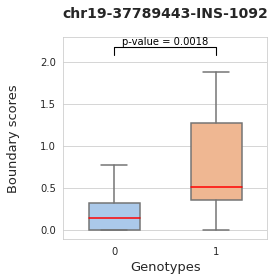

In [145]:
# Set Seaborn's default style and color palette
sns.set_style("whitegrid")
sns.set_palette("pastel")

# Create the boxplot using Seaborn
plt.figure(figsize=(4, 4))  # Adjust the figure size
ax = sns.boxplot(data=df_new[['0', '1']], palette="pastel", medianprops=dict(color='red'), width=0.5)

# Set labels, titles, and other properties
ax.set_ylabel('Boundary scores', fontsize=13, labelpad=20)
ax.set_xlabel('Genotypes', fontsize=13)
ax.set_title('chr19-37789443-INS-1092', pad=20, fontsize=14, fontweight='bold')

# Display the plot
plt.tight_layout()

# statistical annotation
x1, x2 = 0, 1
y, h, col = df_new['1'].max() + 0.2, 0.1, 'k'

plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.1, c=col)
plt.text((x1+x2)*.5, y+h, "p-value = 0.0018", ha='center', va='bottom', color=col)

plt.show()